In [44]:
import os
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data)

In [45]:
from gerrychain import Graph

#read the iowa json county graph
# Define the file path and file name
filepath = '/Users/adenijibabalola/Desktop/DeterministicOperationsResearch/Iowa data/dual_graph'
filename = 'IA_counties.json'

# Use os.path.join to correctly construct the file path
full_path = os.path.join(filepath,filename)
# Load the graph
G = Graph.from_json(full_path)

#Make sure the file is read correctly by printing the node #, and its population
for node in G.nodes:
    print(node, G.nodes[node].get('POP100', 'Population not found'))

0 12943
1 10330
2 12138
3 10033
4 98537
5 10565
6 12329
7 20070
8 492401
9 9814
10 40105
11 17488
12 9110
13 15627
14 5674
15 20646
16 16878
17 26715
18 37813
19 25698
20 93667
21 5896
22 15211
23 11658
24 38910
25 174669
26 33555
27 6605
28 16662
29 14334
30 9388
31 105941
32 16384
33 16525
34 20565
35 6192
36 43127
37 8771
38 35437
39 20482
40 11934
41 3704
42 8751
43 9597
44 10837
45 17135
46 7577
47 43235
48 8634
49 15039
50 10019
51 24988
52 14182
53 10623
54 22565
55 35872
56 14061
57 10679
58 7005
59 13127
60 7645
61 18505
62 20760
63 7078
64 14828
65 14582
66 36999
67 15663
68 16548
69 9469
70 8996
71 4663
72 46460
73 9927
74 7443
75 131144
76 9748
77 19509
78 52403
79 7496
80 12012
81 10795
82 99266
83 18662
84 11746
85 25575
86 6497
87 19485
88 230299
89 17703
90 17043
91 20823
92 14484
93 99678
94 33414
95 22190
96 12317
97 7203
98 152854


In [47]:
## Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01

import math 
# No of districts
k = 4
#Summing up the total population in counties 
total_population = sum(G.nodes[node]['POP100'] for node in G.nodes)

# Equations for bounds
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)

print("Using L =",L,"and U =",U,"and K =",k)

Using L = 793605 and U = 801580 and K = 4


In [48]:
# Begin with model
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut, this satisfies contiguity?

# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )


In [49]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

m.update()

In [50]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY )

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )


In [51]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [52]:
# solve IP model
m.optimize()



Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1716 rows, 1458 columns and 6990 nonzeros
Model fingerprint: 0xe75d93b4
Variable types: 444 continuous, 1014 integer (1014 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.02s
Presolved: 1716 rows, 1458 columns, 6990 nonzeros
Variable types: 444 continuous, 1014 integer (1014 binary)

Root relaxation: objective 0.000000e+00, 745 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  412          -    0.00000      -     -    0s
     0     0    0.13229    0  420          -    0.13229      -     -    0s
     0

In [53]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAMELSAD20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["POP100"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 33.0
District 0 has population 797302 and contains counties ['Wright County', 'Story County', 'Sac County', 'Hardin County', 'Boone County', 'Plymouth County', 'Cherokee County', 'Emmet County', 'Woodbury County', 'Clay County', 'Crawford County', 'Osceola County', 'Cerro Gordo County', 'Greene County', 'Lyon County', 'Monona County', 'Humboldt County', 'Hamilton County', 'Franklin County', "O'Brien County", 'Guthrie County', 'Sioux County', 'Winnebago County', 'Ida County', 'Carroll County', 'Pocahontas County', 'Kossuth County', 'Webster County', 'Palo Alto County', 'Calhoun County', 'Worth County', 'Hancock County', 'Dickinson County', 'Buena Vista County', 'Dallas County']

District 1 has population 796929 and contains counties ['Keokuk County', 'Marshall County', 'Davis County', 'Jasper County', 'Des Moines County', 'Scott County', 'Lee County', 'Iowa County', 'Wapello County', 'Henry County', 'Louisa County', 'Monroe County', 'Muscatine County', 'Lucas 

In [54]:
# To check if satisfies contiguity contraint
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 4, 9, 16, 17, 19, 23, 30, 31, 32, 33, 35, 36, 37, 40, 42, 43, 49, 50, 52, 53, 55, 57, 58, 62, 63, 64, 66, 70, 73, 74, 81, 89, 91, 93] connected? True
Is district = [3, 10, 12, 18, 24, 25, 26, 28, 38, 39, 44, 46, 47, 48, 54, 61, 67, 83, 86, 94, 95, 96, 97, 98] connected? True
Is district = [5, 6, 7, 11, 13, 15, 29, 34, 45, 51, 56, 69, 72, 75, 77, 80, 82, 85, 87, 88, 90] connected? True
Is district = [1, 2, 8, 14, 20, 21, 22, 27, 41, 59, 60, 65, 68, 71, 76, 78, 79, 84, 92] connected? True


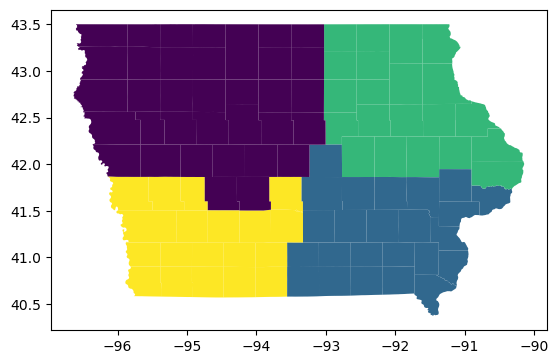

In [55]:
# Let's draw it on a map
import geopandas as gpd

# Read Iowa counties shapefile from "IA_counties.shp"
filepath = '/Users/adenijibabalola/Desktop/DeterministicOperationsResearch/Iowa data/shape_files'
filename = 'IA_counties.shp'

# Use os.path.join to correctly construct the file path
full_path = os.path.join(filepath,filename)

# Read geopandas dataframe from file
df = gpd.read_file(full_path)

# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()